In [1]:
import sys, os     # ONLY RUN THIS CELL ONCE
working_dir = os.path.abspath("../")
sys.path.append(working_dir)
os.chdir(working_dir)

# Finding Vessels with Correlation and a Representative Dataset

In order to find the optic disc in retinal images, the network of vessels can be considered and known patterns in the network can be helpful when locating the optic disc. In this notebook, the main blood vessels will be used to identify the location of the known parabola in the images. An example of the said method is given in the diagram below.

![Diagram of fitted parabola in the veins](eye_parabola.png "Retinal image with parabola fitting.")

To achieve this, a representative dataset will be used to calculate how well parts of the retinal images correlate with the vessel dataset. The outline of the proposed method is given in the list below.

1. Acquire sections of retinal images which represent vessels.
2. Use Principal Component Analysis to devise images which can reconstruct an arbitrary vessel image.
3. For any given section of a retinal image, reconstruct the said section using the principal components.
4. Calculate how well the reconstruction correlate with the original section.

The cell below will load and display the dataset generated for this experiment. It consists of 60 images of vessel sections taken from the preprocessed MESIDOR retinal images.

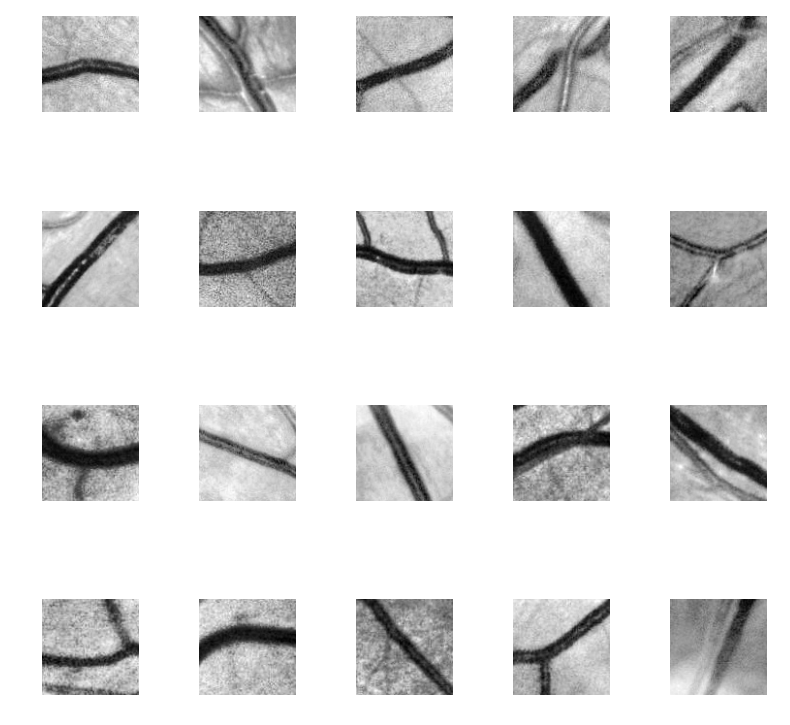

In [2]:
%matplotlib inline
import cv2, files
import numpy as np
import utilities as ut
from matplotlib import pyplot as plt


# Load the image paths form the folder
vessel_file_path = "../images/vessel_pca"
vessel_paths = files.get_images(vessel_file_path)

# Shuffle the names so images are randomized in grid
from random import shuffle
shuffle(vessel_paths)

# Show the images in the grid
fig = plt.figure(figsize=(8,8))
for i in range(20):
    image = ut.read_image(vessel_paths[i], "BGR2GRAY")
    ax = plt.subplot(4,5,i+1)
    ax.set_axis_off()
    ax.imshow(image, cmap="gray")
fig.tight_layout(); plt.show();

## PCA Reconstruction for Images

Principal Component Analysis is a dimentionality reduction learning algorithm which reduces the feature space of samples while preserving the variance of the data. PCA is classed as unsupervised learning since, initialy, the variance of the samples is unknown.

PCA is usually applied to datasets where the dimentionality of the samples, $d$, is large and the learning process would require a large amount of computational power. The output of running PCA on said dataset is a new basis (set of orthonormal vectors that span the dataset). The number of elements in this basis, $m$ is much much smaller than $d$, and the vectors in the basis are the principal components of the data.

The principal components of a dataset are simply the eigenvectors of the covariance matrix $\mathbf{S}$, where the corresponding eigenvalues are the variances of the components. The derivation of this method is shown in the [book by I. T. Jolliffe](https://link.springer.com/chapter/10.1007/978-1-4757-1904-8_7). Recall that the covariance matrix $\mathbf{S}$ can be calculated as

$$
\begin{align}
    \mathbf{S} &= \frac{\sum_{i}^{n} (x_i - \mu)(x_j - \mu)^\top}{n}
\end{align}
$$

where $\mu = \sum_1^n x_i$ is the mean of the dataset. Now define $\mathbf{V}$ as the matrix containing the eigenvectors $\nu_1, \dots, \nu_N$ of $\mathbf{S}$ as its columns. Note that the eigenvectors in $\mathbf{V}$ are sorted by the eigenvalues in descending order.

Once the matrix $\mathbf{V}$ has been defined, it is possible to project the dataset onto the new eigenvector space. Let matrix $\underset{(N\times d)}{\mathbf{U}}$ be the matrix containing all the $N$ original data points in its rows. Since all the eigenvectors are orthonormal, the projection of a datapoint onto an eigenvector is simply the dot product of the vectors in question. Hence the reconstruction of the dataset using the principal components is simply $\mathbf{P} = \mathbf{U}\mathbf{V}\mathbf{V}^\top$. Note that dimentionality reduction happens when $\mathbf{V}$ only contains the first $m$ eigenvectors.

In the context of face recognition, [Turk and Pentland](https://ieeexplore-ieee-org.sheffield.idm.oclc.org/document/139758/) suggested a way to use PCA in order to find locations of faces in given images. The proposed method consists of learning the principal compoenents from a face dataset, then using sliding window algorithms in order to find the locations which are best reconstructed using PCA. This idea is extended in this notebook to find the well correlated vessel areas.

Numpy's linear algebra library provides methods for calculating the eigenvectors of a matrix, sorted by the eigenvalues. The next cell will calculate the principal components for the aforementioned vessel dataset and display the first few principal components.

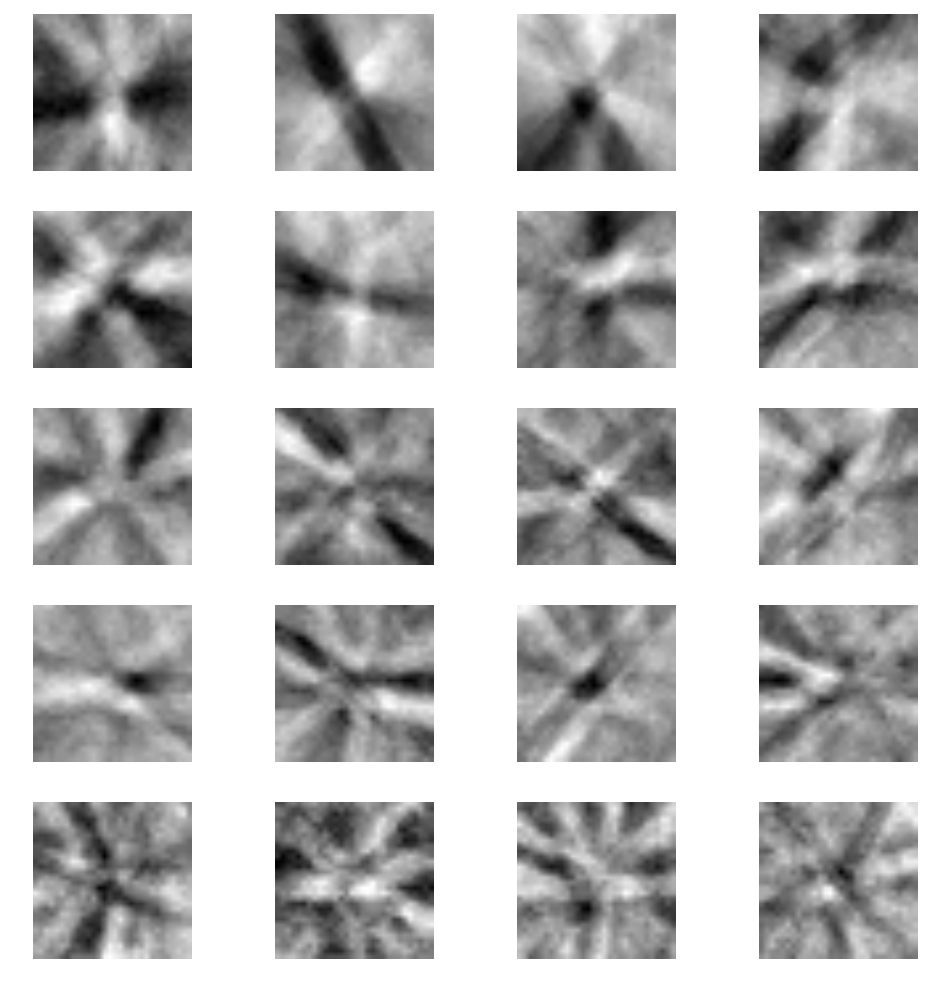

In [3]:
# Open images as matrix (treat them as N^2 vectors)
img_objs = [ut.read_image(path, "BGR2GRAY") for path in vessel_paths]
# Resize them to (30x30) to make calculation faster
resized_objs = [cv2.resize(img,(30,30), cv2.INTER_AREA) for img in img_objs]
vector_objs = [np.ravel(img) for img in resized_objs]
img_matrix = np.vstack(vector_objs) # (30*30 x 60)

# Get the mean and the covariance
covariance = np.cov(img_matrix, rowvar=False)

# Get the eigenvectors with eigh. This function
# gets eigenvalues and eigenvectors of symmetric 
# matrices and is a lot faster than linalg.eig.
from numpy.linalg import eigh as eig
w, v = eig(covariance)


# Ony use the first 20 principal components. 
# Note that eigh returns the vectors in ascending
# order of eigenvalue, hence why the flip.
v_order = np.fliplr(v)[:,:20] 

# Plot all the PCAs
fig = plt.figure(figsize=(10,10))
for i in range(20): # Go throught 10 PCAs
    pca = v_order[:,i]
    pca_img = pca.reshape((30,30))
    
    ax = plt.subplot(5,4,i+1)
    ax.set_axis_off()
    ax.imshow(pca_img, cmap="gray")
fig.tight_layout(); plt.show();

#### Reconstrution Example

In the next cell, a random image from the dataset will be loaded, and a section of the image (with size corresponding to principal components' sizes) will be reconstructed. The reconstructed image is not exactly the same as the image (since only the 20 principal components are being used as opposed to 900), but it correlates well with the image, which is exaclty what was expected. In addition, if the section is defined as a part of the image where the vessels are not present, it can be seen that this correlation is not there.

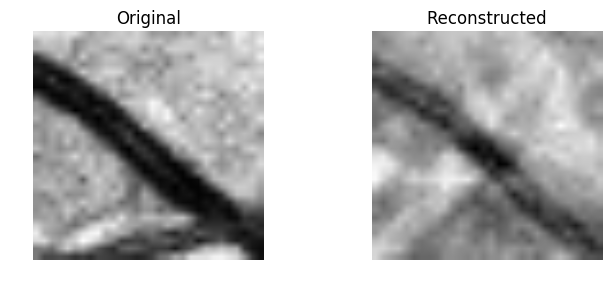

In [4]:
# Load the images from the mesidor dataset
dataset_path = "../images/output2"
# List with all the paths 
dataset_paths = files.get_images(dataset_path)

# Get a random image as our test image
image = ut.read_image(dataset_paths[0], "BGR2GRAY")

# Get a section of the image for reconstruction,
# same size as template vessels
section = image[100:200,700:800] # Resize to same as PCAs
section = cv2.resize(section, (30,30), cv2.INTER_AREA)
# Ravel so we have 1D array (NxN)
raveled = np.ravel(section)

# Get the projections (weights for each PC)
weights = np.dot(raveled, v_order)
# Reconstruct the image
recons = np.dot(weights, v_order.T)
recons_img = recons.reshape(30,30) # 2D array 

# Plot the result
fig = plt.figure(figsize=(7, 3))
ax1 = plt.subplot(1,2,1)
ax1.set_axis_off(); ax1.set_title("Original")
ax1.imshow(section, cmap="gray")
ax2 = plt.subplot(1,2,2)
ax2.set_axis_off(); ax2.set_title("Reconstructed")
ax2.imshow(recons_img, cmap="gray")
fig.tight_layout(); plt.show();

## Image Correlation to Measure Similarity

PCA provides an efficient way to reconstruct known patterns from unseen data. In this case, the sections of retinal images where the vessels are present are being reconstructed with the vessel PCA. Without loss of generality, it can be said that the reconstructd and original vessel sections are similar.

There are several ways to measure the similarity of images. Unfortunately, a simple euclidean ditance measure would not yield good results due to the noise in the original image and the colour difference in the reconstruction pixels. For this reason, different methods of correlation measure were considered. The list below contains the considered OpenCV correlation methods and brief descriptions of the suitability of each method.

* TM_CORR - This method simply gets the mathematical correlation of each pixel in the given images. Note that the values used are the pixel intensities, hence the diffference in colour in the reconstructed image may still affect the results of this method.

$$
R(x,y) = \sum_{x',y'} (T(x',y') \cdot I(x+x', y+y'))
$$

* TM_CCORR_NORMED - This method is simple the above method over a factor of $\sqrt{\sum_{x',y'} T(x',y')^2 \cdot \sum_{x',y'} I(x+x',y+y')^2}$ which is the upper bound for the correlation value. Similar to the previous method, this still depends on the colour similarity. <br>


* TM_CCOEFF - This method compares the derivatives of each image as opposed to the intensities.

$$
R(x,y) = \sum_{x',y'} (T'(x',y') \cdot I'(x+x', y+y'))
$$

* TM_CCOEFF_NORMED - Same calculation as above but over a the upper bound for the correlation value discussed previously.

Note that $R(x,y)$ represent the correlation value for the window starting at location $(x,y)$. However, both the reconstruction and the original sections have the same size, meaning that this value is always a scalar, not a matrix. This notation was used because the OpenCV function `matchTemplate` works for cases where the images being matched are not the same size.

Since the reconstruction images do not have the exact same intensity values as the original sections, but the structure is essentially the same, the best correlation methods to use are wither TM_CCOEFF or TM_CCOEFF_NORMED. These methods will multiply the intensity derivatives together, hence if the structure of the images are the same, this should yield a high correlation result. An outline of the final vessel recognition algorithm is shown below.

1. Load a retinal image.
2. Divide the image into sections which are the same size as the principal principal components (sliding window manner).
3. Create a matrix (same dims as image) to store the correlation values for each pixel. 
4. Reconstruct these sections using the first $N$ principal components.
5. Use OpenCV's `matchTemplate` to calculate the correlation of each pixel and store in correlation matrix.

The cell below implements the algorithm above.

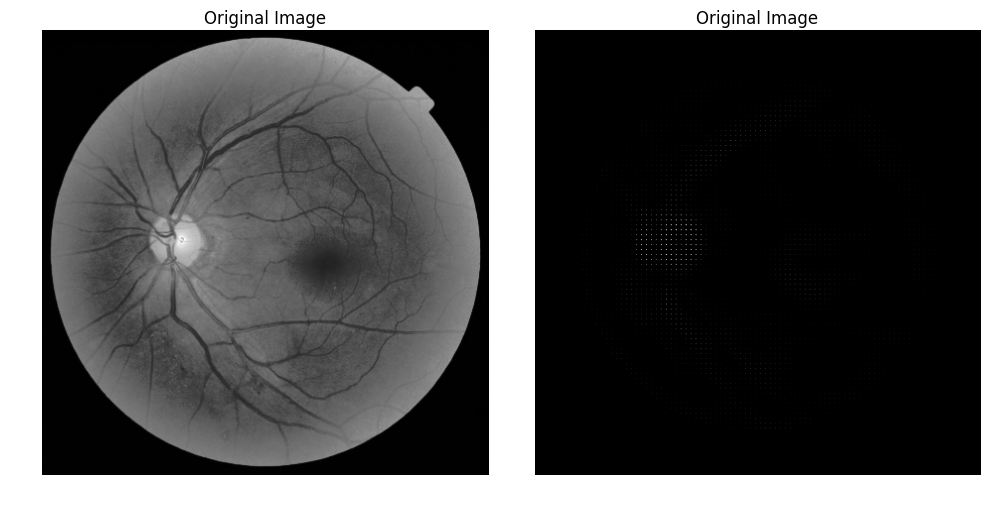

In [5]:
# Get the test image
image = ut.read_image(dataset_paths[10], "BGR2GRAY")
# Resize with the factor used to resize the vessel images
image = cv2.resize(image, (450,450), cv2.INTER_AREA)
# Image sze for the sliding window algorithm
N, _ = image.shape

# Create the correlation array
corr_array = np.zeros(image.shape)

# Settings (window size)
width, height = 30, 30

# Sliding algorithm (y,x is the center pixel)
offset = np.max([width, height])//2 + 2 # The offset from the boarders
for y in range(offset, N-offset, 5):
    for x in range(offset, N-offset, 5):
        
        # Tuples to represent the window box
        starts = np.array([y-height/2, x-width/2], dtype=int)
        stops = np.array([starts[0]+height, starts[1]+width], dtype=int)
        
        window = image[starts[0]:stops[0], starts[1]:stops[1]]

        # PCA reconstruction
        weights = np.dot(np.ravel(window), v_order)
        recons = np.sum(weights*v_order, axis=1).astype("uint8")
        
        # Set the value of the comparing matrix
        corr_array[y,x] = cv2.matchTemplate(recons.reshape(height,width), window, cv2.TM_CCOEFF)
        
# Normalise the array
corr_array[corr_array < 0] = 0 # Threshold by 0
cv2.normalize(corr_array, corr_array, 0, 255, cv2.NORM_MINMAX)

# Create the circular mask (from the center) to remove
# the iamge circular boarders.
Xs = np.ones((N,N))*np.arange(N)
Ys = Xs.T
r = 180 # Radius (from center) in pixels
s = np.floor(N/2) # Displacement
Xs, Ys = Xs - s, Ys - s
Dist = Xs*Xs + Ys*Ys
mask = Dist < r**2

corr_array *= mask

fig = plt.figure(figsize=(10, 7))
ax1 = plt.subplot(1,2,1) 
ax1.set_title("Original Image")
ax1.set_axis_off()
ax1.imshow(image, cmap="gray")
ax2 = plt.subplot(1,2,2)
ax2.set_title("Original Image")
ax2.set_axis_off()
ax2.imshow(corr_array, cmap="gray")
fig.tight_layout(); plt.show();

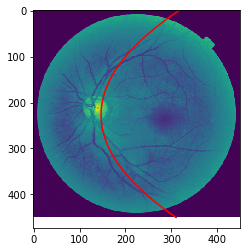

In [7]:
# Generating the points
max_weight = 5
cv2.normalize(corr_array, corr_array, 0, max_weight, cv2.NORM_MINMAX)
corr_array = np.round(corr_array)
points = np.empty((2,0), dtype=int)

for w in range(1, max_weight):
    # Corresponding layer in depth matrix is bool repr.
    # corresponding weight locations
    coords = np.vstack(np.where(corr_array == w))
    points = np.hstack((points, np.repeat(coords, w, axis=1)))

from scipy.optimize import curve_fit

def func(x, a, b, c):
    return a*x**2 + b*x + c

params, ppcov = curve_fit(func, points[0,:], points[1,:])
b, c, d = params

Xs = np.linspace(0, 450, 2000)
Ys = b*Xs**2 + c*Xs + d

plt.imshow(image)
plt.plot(Ys, Xs, "r");

In [ ]:
keypoints = detector.detect

In [ ]:
keypoints = detector.detect